In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report as cr
from sklearn.metrics import accuracy_score as accu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from sklearn.ensemble import GradientBoostingClassifier as gbc

from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.tree import DecisionTreeClassifier as dtc

In [2]:
# load master dataset
df = pd.read_csv("h1b_dataset.csv", encoding = "ISO-8859-1")

E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR,DECISION_DAY,DECISION_MONTH,DECISION_YEAR,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYER_COUNTRY,...,PW_SOURCE_YEAR,PW_SOURCE_OTHER,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,H-1B_DEPENDENT,WILLFUL_VIOLATOR,WORKSITE_STATE,WORKSITE_POSTAL_CODE,CASE_STATUS
0,24,2,2016,1,10,2016,H1B,DISCOVER PRODUCTS INC,IL,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,65811.0,67320.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
1,4,3,2016,1,10,2016,H1B,DFS SERVICES LLC,IL,UNITED STATES OF AMERICA,...,2015.0,WILLIS TOWERS WATSON SURVEY,53000.0,57200.0,Year,N,N,IL,60015,CERTIFIEDWITHDRAWN
2,10,3,2016,1,10,2016,H1B,EASTBANC TECHNOLOGIES LLC,DC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,77000.0,0.0,Year,Y,N,DC,20007,CERTIFIEDWITHDRAWN
3,28,9,2016,1,10,2016,H1B,INFO SERVICES LLC,MI,UNITED STATES OF AMERICA,...,2016.0,OFLC ONLINE DATA CENTER,102000.0,0.0,Year,Y,N,NJ,7302,WITHDRAWN
4,22,2,2015,2,10,2016,H1B,BBandT CORPORATION,NC,UNITED STATES OF AMERICA,...,2015.0,OFLC ONLINE DATA CENTER,132500.0,0.0,Year,N,N,NY,10036,CERTIFIEDWITHDRAWN


In [4]:
#extract samples with labels: denined/certified
df_binary = df.loc[df['CASE_STATUS'] == 'DENIED']
df_binary = df_binary.append(df.loc[df['CASE_STATUS'] == 'CERTIFIED'])
df_binary.shape

(475952, 27)

In [8]:
#number of samples with label = 'DENIED'
n_denied = len(df_binary[df_binary.CASE_STATUS == 'DENIED'])

n_certi = len(df_binary[df_binary.CASE_STATUS == 'CERTIFIED'])
n_denied

6983

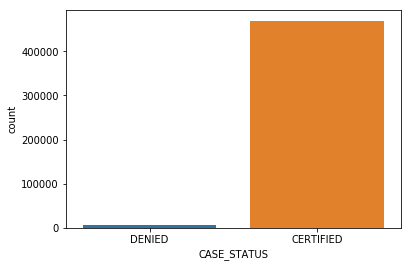

In [6]:
sns.countplot(df_binary['CASE_STATUS'])

In [9]:
#balance dataset for both labels
df_final = pd.DataFrame()
df_final = df_binary.loc[df_binary.CASE_STATUS == 'CERTIFIED'].sample(n_denied, random_state=42)\
            .append(df_binary.loc[df_binary.CASE_STATUS=='DENIED'])

In [10]:
print("Number of DENIED samples:",list(df_final['CASE_STATUS']).count('DENIED'))
print("Number of CERTIFIED samples:", list(df_final['CASE_STATUS']).count('CERTIFIED'))
print("Shape of combined dataset:",df_final.shape)

Number of DENIED samples: 6983
Number of CERTIFIED samples: 6983
Shape of combined dataset: (13966, 27)


In [11]:
# There are multiple visa classes in dataset
df_final['VISA_CLASS'].value_counts()

H1B               13060
E3 Australian       791
H1B1 Chile           66
H1B1 Singapore       49
Name: VISA_CLASS, dtype: int64

In [12]:
# Keep samples having visa_class = 'H1B'
df_final = df_final[df_final.VISA_CLASS == 'H1B']
df_final.shape

(13060, 27)

In [13]:
# utility function to rescale wages to 'yearly'
def rescale_wage(value, type_):
    
    v = value
    
    if type_ == 'Month':
        v *= 12    
    if type_ == 'Week':
        v *= 52
    if type_ == 'Hour':
        v *= 40 * 52
    if type_ == 'Bi-Weekly':
        v *= 26 
    return v
        

In [16]:
# rescale wage_rate_of_pay and prevailing_wage to 'yearly'
df_final['PREVAILING_WAGE'] = df_final[['PREVAILING_WAGE', 'PW_UNIT_OF_PAY']]\
                    .apply(lambda x: rescale_wage(x['PREVAILING_WAGE'], x['PW_UNIT_OF_PAY']), axis=1)

df_final['WAGE_RATE_OF_PAY_FROM'] = df_final[['WAGE_RATE_OF_PAY_FROM', 'WAGE_UNIT_OF_PAY']]\
                    .apply(lambda x: rescale_wage(x['WAGE_RATE_OF_PAY_FROM'], x['WAGE_UNIT_OF_PAY']), axis=1)

print(df_final['WAGE_RATE_OF_PAY_FROM'].head())
print(df_final['PREVAILING_WAGE'].head())

184141    115000.0
490923    129323.0
20786      75000.0
277751     60000.0
107933     95000.0
Name: WAGE_RATE_OF_PAY_FROM, dtype: float64
184141    110219.0
490923    129323.0
20786      53019.0
277751     48838.0
107933     90813.0
Name: PREVAILING_WAGE, dtype: float64


In [14]:
#check for null values and data types
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13060 entries, 184141 to 528112
Data columns (total 27 columns):
CASE_SUBMITTED_DAY       13060 non-null int64
CASE_SUBMITTED_MONTH     13060 non-null int64
CASE_SUBMITTED_YEAR      13060 non-null int64
DECISION_DAY             13060 non-null int64
DECISION_MONTH           13060 non-null int64
DECISION_YEAR            13060 non-null int64
VISA_CLASS               13060 non-null object
EMPLOYER_NAME            13057 non-null object
EMPLOYER_STATE           13060 non-null object
EMPLOYER_COUNTRY         13060 non-null object
SOC_NAME                 13060 non-null object
NAICS_CODE               13058 non-null float64
TOTAL_WORKERS            13060 non-null int64
FULL_TIME_POSITION       13058 non-null object
PREVAILING_WAGE          13060 non-null float64
PW_UNIT_OF_PAY           13039 non-null object
PW_SOURCE                13039 non-null object
PW_SOURCE_YEAR           13040 non-null float64
PW_SOURCE_OTHER          13060 non-null obj

In [15]:
#remove unnecessary columns

df_final = df_final.drop(columns=['EMPLOYER_COUNTRY', 'CASE_SUBMITTED_DAY', 'CASE_SUBMITTED_MONTH', 'CASE_SUBMITTED_YEAR',
'DECISION_DAY', 'DECISION_MONTH', 'DECISION_YEAR', 'EMPLOYER_COUNTRY', 'NAICS_CODE', 'PW_UNIT_OF_PAY', 'PW_SOURCE',
'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER', 'WAGE_RATE_OF_PAY_TO', 'WILLFUL_VIOLATOR', 'WORKSITE_POSTAL_CODE',
                            'EMPLOYER_STATE', 'VISA_CLASS', 'WORKSITE_STATE', 'WAGE_UNIT_OF_PAY'])
print(df_final.shape)

(13060, 8)


In [19]:
#drop columns with null values
df_final.dropna(inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13165 entries, 184141 to 528112
Data columns (total 8 columns):
EMPLOYER_NAME            13165 non-null object
SOC_NAME                 13165 non-null object
TOTAL_WORKERS            13165 non-null int64
FULL_TIME_POSITION       13165 non-null object
PREVAILING_WAGE          13165 non-null float64
WAGE_RATE_OF_PAY_FROM    13165 non-null float64
H-1B_DEPENDENT           13165 non-null object
CASE_STATUS              13165 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 925.7+ KB


In [16]:
#final counts for each label
df_final['CASE_STATUS'].value_counts()

CERTIFIED    6834
DENIED       6226
Name: CASE_STATUS, dtype: int64

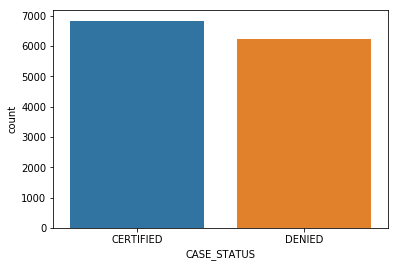

In [17]:
sns.countplot(df_final['CASE_STATUS'])

In [18]:
# new features/columns
# diff_wage_prevail
df_final['diff_wage_prevailing'] = df_final.apply(lambda x: abs(x['PREVAILING_WAGE'] - x['WAGE_RATE_OF_PAY_FROM']), axis=1)

#combined employer+soc_name/position
# df_final['combined_empl_soc'] = df_final.apply(lambda x: x['EMPLOYER_NAME'] + "_" + x['SOC_NAME'], axis=1)

In [87]:
#df_final.diff_wage_prevailing

In [58]:
# df_final['combined_empl_soc']

In [59]:
# columns to be converted in numerical range
# EMPLOYER_NAME
# SOC_NAME
# FULL_TIME_POSITION

In [19]:
# FULL_TIME_POSITION : Y = 1, N = 0
df_final.replace({'FULL_TIME_POSITION' : { 'Y' : 1, 'N' : 0}}, inplace=True)
# df_final['FULL_TIME_POSITION'].head()

# H1B dependent: Y=1, N=0
df_final.replace({'H-1B_DEPENDENT' : { 'Y' : 1, 'N' : 0}}, inplace=True)

#WILLFUL_VIOLATOR: Y=1, N=0
# df_final.replace({'WILLFUL_VIOLATOR' : { 'Y' : 1, 'N' : 0}}, inplace=True)

df_final.head()

,EMPLOYER_NAME,SOC_NAME,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,WAGE_RATE_OF_PAY_FROM,H-1B_DEPENDENT,CASE_STATUS,diff_wage_prevailing
184141,THOMSON REUTERS HOLDINGS INC,COMPUTER OCCUPATION,1,1.0,110219.0,115000.0,0.0,CERTIFIED,4781.0
490923,PAYPAL INC,COMPUTER OCCUPATION,1,1.0,129323.0,129323.0,0.0,CERTIFIED,0.0
277751,HRTRONIX LLC,COMPUTER OCCUPATION,5,1.0,48838.0,60000.0,0.0,CERTIFIED,11162.0
107933,AMERICAN EXPRESS TRAVEL RELATED SERVICES COMPA...,ANALYSTS,1,1.0,90813.0,95000.0,0.0,CERTIFIED,4187.0
520727,NOBLE RESEARCH INSTITUTE LLC,COMPUTER OCCUPATION,1,1.0,38043.0,38043.0,0.0,CERTIFIED,0.0


In [20]:
# EMPLOYER_NAME: 
print(len(set(df_final.EMPLOYER_NAME.value_counts())))

#SOC_NAME
len(set(df_final.SOC_NAME.value_counts()))

45


41

In [62]:
# from sklearn.preprocessing import OneHotEncoder

In [21]:
# Deal with outliers

df_outl = df_final[df_final.PREVAILING_WAGE < 150000]
df_outl = df_outl[df_outl.WAGE_RATE_OF_PAY_FROM < 150000]
sorted(df_outl['PREVAILING_WAGE'], reverse=True)

[149573.0,
 149573.0,
 149011.0,
 148200.0,
 148013.0,
 147846.0,
 147846.0,
 147846.0,
 147846.0,
 147846.0,
 147846.0,
 147846.0,
 147430.0,
 147222.0,
 147222.0,
 147222.0,
 147222.0,
 147222.0,
 147222.0,
 147222.0,
 147222.0,
 147222.0,
 147126.0,
 146702.0,
 146058.0,
 146058.0,
 145000.0,
 144776.0,
 144347.0,
 144347.0,
 144248.0,
 144140.0,
 143938.0,
 143790.0,
 143762.0,
 143749.0,
 143562.0,
 143458.0,
 143350.0,
 143257.0,
 143126.0,
 142938.0,
 142938.0,
 142938.0,
 142938.0,
 142938.0,
 142938.0,
 142938.0,
 142938.0,
 142938.0,
 142938.0,
 142709.0,
 142618.0,
 142605.0,
 142403.0,
 141835.0,
 141669.0,
 141419.0,
 141003.0,
 140754.0,
 140666.0,
 140109.0,
 140000.0,
 139838.0,
 139402.0,
 138994.0,
 138965.0,
 138965.0,
 138965.0,
 138965.0,
 138965.0,
 138923.0,
 138923.0,
 138715.0,
 138636.0,
 138261.0,
 138154.0,
 138091.0,
 137821.0,
 137682.0,
 137571.0,
 137390.0,
 137010.0,
 136906.0,
 136906.0,
 136906.0,
 136906.0,
 136906.0,
 136906.0,
 136760.0,
 136679.0,

In [22]:
# df_outl.to_csv('h1b_preprocessed_all_features.csv')

X = df_outl.drop(columns = ['CASE_STATUS'])
y = df_outl['CASE_STATUS']


In [23]:
X_encoded = pd.get_dummies(X)#categorical_cols['SOC_NAME'])


In [24]:
X_encoded.head()

,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,WAGE_RATE_OF_PAY_FROM,H-1B_DEPENDENT,diff_wage_prevailing,EMPLOYER_NAME_1199 SEIU UNITED HEALTHCARE WORKERS EAST,EMPLOYER_NAME_14 W ADMINISTRATIVE SERVICES LLC,EMPLOYER_NAME_18|8 SOLUTIONS INC,EMPLOYER_NAME_1A DISTRIBUTION INC,...,SOC_NAME_PUBLIC RELATIONS,SOC_NAME_REAL ESTATE,SOC_NAME_RELIGIOUS WORKERS,SOC_NAME_REPORTERS AND CORRESPONDENTS,SOC_NAME_SALES AND RELATED WORKERS,SOC_NAME_SCIENTIST,SOC_NAME_SOCIAL WORKERS,SOC_NAME_SURVEYORS,SOC_NAME_TRANSPORTATION,SOC_NAME_WRITERS EDITORS AND AUTHORS
184141,1,1.0,110219.0,115000.0,0.0,4781.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
490923,1,1.0,129323.0,129323.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
277751,5,1.0,48838.0,60000.0,0.0,11162.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107933,1,1.0,90813.0,95000.0,0.0,4187.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
520727,1,1.0,38043.0,38043.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


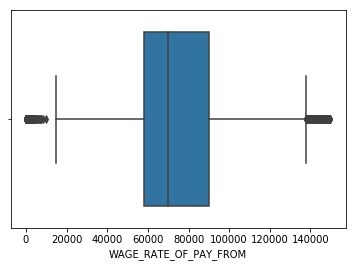

In [25]:
sns.boxplot(X_encoded['WAGE_RATE_OF_PAY_FROM'])

In [26]:
x_transformed = MinMaxScaler().fit_transform(X_encoded)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [27]:
df_trans = pd.DataFrame(x_transformed, columns=X_encoded.columns)
print(df_trans.shape)
df_trans.tail()

(12480, 6791)


,TOTAL_WORKERS,FULL_TIME_POSITION,PREVAILING_WAGE,WAGE_RATE_OF_PAY_FROM,H-1B_DEPENDENT,diff_wage_prevailing,EMPLOYER_NAME_1199 SEIU UNITED HEALTHCARE WORKERS EAST,EMPLOYER_NAME_14 W ADMINISTRATIVE SERVICES LLC,EMPLOYER_NAME_18|8 SOLUTIONS INC,EMPLOYER_NAME_1A DISTRIBUTION INC,...,SOC_NAME_PUBLIC RELATIONS,SOC_NAME_REAL ESTATE,SOC_NAME_RELIGIOUS WORKERS,SOC_NAME_REPORTERS AND CORRESPONDENTS,SOC_NAME_SALES AND RELATED WORKERS,SOC_NAME_SCIENTIST,SOC_NAME_SOCIAL WORKERS,SOC_NAME_SURVEYORS,SOC_NAME_TRANSPORTATION,SOC_NAME_WRITERS EDITORS AND AUTHORS
12475,0.0,1.0,0.519399,0.567575,1.0,0.053402,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12476,0.0,1.0,0.510079,0.509442,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12477,0.0,1.0,0.299680,0.299306,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12478,0.0,1.0,0.610899,0.605048,1.0,0.005565,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12479,0.0,1.0,0.509577,0.510817,0.0,0.002052,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# pd.DataFrame(df_trans).to_csv('h1b_normalized_all_features.csv')

print(df_trans['H-1B_DEPENDENT'].value_counts())
# print(df_trans['WILLFUL_VIOLATOR'].value_counts())

0.0    8790
1.0    3689
Name: H-1B_DEPENDENT, dtype: int64


In [32]:


X_train, X_test, y_train, y_test = train_test_split(df_trans, y, random_state=0, test_size=0.3)

X_train.shape

(8736, 6791)

In [33]:
X_test.shape

(3744, 6791)

In [108]:
from sklearn.feature_selection import SelectFromModel
#Feature importance using RandomForests


### Feature Importance using RandomForests

In [31]:
rf_clf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [101]:
features = X_train.columns
importances = rf_clf.feature_importances_

# top 70 features give best accuracy (combined_empl_soc was not included)
indices = np.argsort(importances)[::-1][:20]

importances[indices]

array([0.08704632, 0.08336751, 0.07373136, 0.06441383, 0.05402578,
       0.03305675, 0.02771256, 0.01758737, 0.01367814, 0.0131124 ,
       0.0128028 , 0.01139359, 0.00551803, 0.00539696, 0.00481688,
       0.00459141, 0.00438318, 0.00423408, 0.00416659, 0.00405103])

In [102]:
# Print the names of the most important features

feat_labels = X_encoded.columns
imp_features = []

for feature_list_index in indices:
    imp_features.append(feat_labels[feature_list_index])
    
len(imp_features)

20

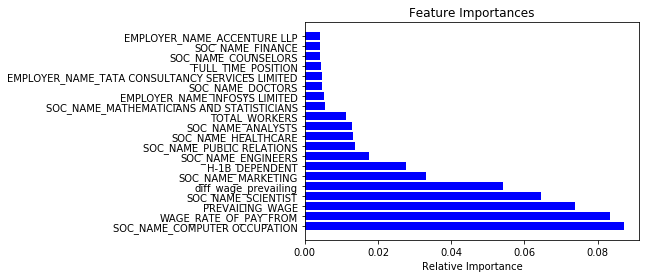

In [103]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [215]:
# X_encoded[imp_features].to_csv('h1b_preprocessed_imp_features.csv')
# len(imp_features)

In [216]:
# pd.DataFrame(x_transformed)[imp_features].to_csv('h1b_normalized_imp_features.csv')
# len(imp_features)

In [104]:
#extract important features
X_imp_train = X_train[imp_features]
X_imp_test = X_test[imp_features]

In [127]:
#Dictionary for finding AUC
d = {'CERTIFIED': 1, 'DENIED': 0}

### Applying models

              precision    recall  f1-score   support

   CERTIFIED       0.77      0.82      0.80      1902
      DENIED       0.80      0.74      0.77      1786

   micro avg       0.78      0.78      0.78      3688
   macro avg       0.78      0.78      0.78      3688
weighted avg       0.78      0.78      0.78      3688

0.7819956616052061


0.8544019497364123


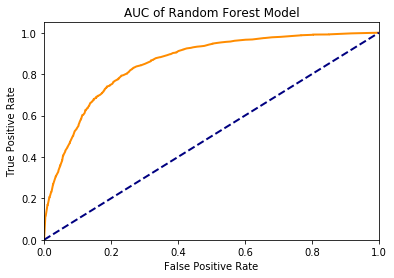

In [161]:
#using imp features
clf_rf = RandomForestClassifier(n_estimators=100)
clf_fit = clf_rf.fit(X_imp_train, y_train) 
preds = clf_fit.predict(X_imp_test)
print(cr(y_test, preds))

print(accu(y_test, preds))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=clf_fit.predict_proba(X_imp_test)
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.79      0.87      0.83      1902
      DENIED       0.84      0.76      0.80      1786

   micro avg       0.81      0.81      0.81      3688
   macro avg       0.82      0.81      0.81      3688
weighted avg       0.82      0.81      0.81      3688

0.8145336225596529


0.8915236863889371


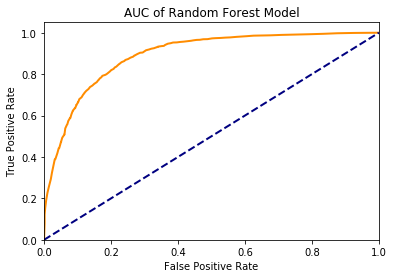

In [163]:
#using all features
clf_rf = RandomForestClassifier(n_estimators=100)
clf_fit = clf_rf.fit(X_train, y_train) 

preds = clf_fit.predict(X_test)

print(cr(y_test, preds))

print(accu(y_test, preds))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=clf_fit.predict_proba(X_test) #X_test = all features
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

In [157]:
from sklearn import svm

preds_svm = svm.LinearSVC().fit(X_train, y_train).predict(X_test)

print(cr(y_test, preds_svm))

print(accu(y_test, preds_svm))


              precision    recall  f1-score   support

   CERTIFIED       0.79      0.88      0.83      1902
      DENIED       0.85      0.74      0.80      1786

   micro avg       0.81      0.81      0.81      3688
   macro avg       0.82      0.81      0.81      3688
weighted avg       0.82      0.81      0.81      3688

0.8145336225596529


In [158]:
# from sklearn import svm

preds_svm = svm.LinearSVC().fit(X_imp_train, y_train).predict(X_imp_test)

print(cr(y_test, preds_svm))

print(accu(y_test, preds_svm))

              precision    recall  f1-score   support

   CERTIFIED       0.76      0.88      0.82      1902
      DENIED       0.84      0.71      0.77      1786

   micro avg       0.80      0.80      0.80      3688
   macro avg       0.80      0.79      0.79      3688
weighted avg       0.80      0.80      0.79      3688

0.7952819956616052


In [393]:
# preds_svm = svm.SVC(kernel='rbf').fit(X_imp_train, y_train).predict(X_imp_test)

# print(cr(y_test, preds_svm))

# print(accu(y_test, preds_svm))

              precision    recall  f1-score   support

   CERTIFIED       0.74      0.86      0.79      1902
      DENIED       0.82      0.67      0.74      1786

   micro avg       0.77      0.77      0.77      3688
   macro avg       0.78      0.77      0.77      3688
weighted avg       0.78      0.77      0.77      3688

0.7697939262472885


0.838577709795665


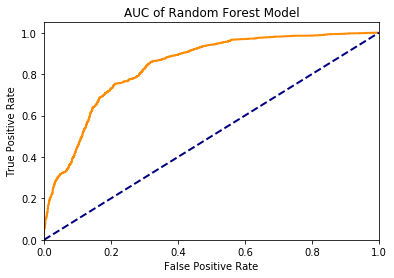

In [164]:
from sklearn.naive_bayes import MultinomialNB
mnb_fit = MultinomialNB().fit(X_imp_train, y_train)
preds_mnb = mnb_fit.predict(X_imp_test)

print(cr(y_test, preds_mnb))

print(accu(y_test, preds_mnb))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=mnb_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.76      0.89      0.82      1902
      DENIED       0.86      0.69      0.77      1786

   micro avg       0.80      0.80      0.80      3688
   macro avg       0.81      0.79      0.79      3688
weighted avg       0.81      0.80      0.79      3688

0.7955531453362256


0.8819500131293398


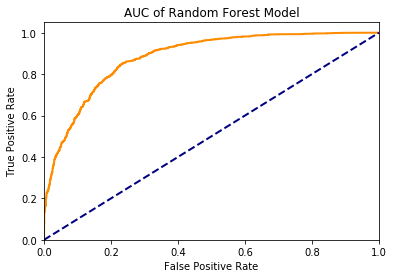

In [165]:
# from sklearn.naive_bayes import MultinomialNB
mnb_fit = MultinomialNB().fit(X_train, y_train)
preds_mnb = mnb_fit.predict(X_test)

print(cr(y_test, preds_mnb))

print(accu(y_test, preds_mnb))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=mnb_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.76      0.82      0.79      1902
      DENIED       0.79      0.73      0.75      1786

   micro avg       0.77      0.77      0.77      3688
   macro avg       0.77      0.77      0.77      3688
weighted avg       0.77      0.77      0.77      3688

0.7716919739696312


0.835067672032622


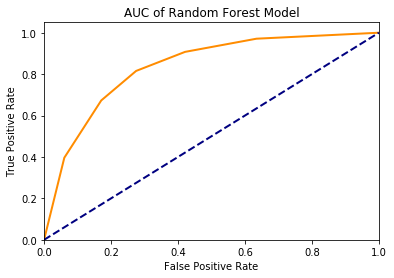

In [166]:

knn_fit = knn().fit(X_imp_train, y_train)
preds_knn = knn_fit.predict(X_imp_test)

print(cr(y_test, preds_knn))

print(accu(y_test, preds_knn))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=knn_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.78      0.84      0.81      1902
      DENIED       0.82      0.74      0.78      1786

   micro avg       0.79      0.79      0.79      3688
   macro avg       0.80      0.79      0.79      3688
weighted avg       0.80      0.79      0.79      3688

0.7947396963123644


0.8615022437629748


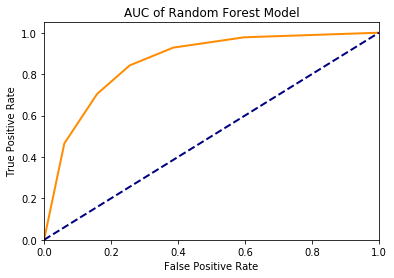

In [167]:
# from sklearn.neighbors import KNeighborsClassifier as knn
knn_fit = knn().fit(X_train, y_train)
preds_knn = knn_fit.predict(X_test)

print(cr(y_test, preds_knn))

print(accu(y_test, preds_knn))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=knn_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

C:\Users\user\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

   CERTIFIED       0.81      0.81      0.81      1902
      DENIED       0.80      0.79      0.80      1786

   micro avg       0.80      0.80      0.80      3688
   macro avg       0.80      0.80      0.80      3688
weighted avg       0.80      0.80      0.80      3688

0.8039587852494577


0.8636232503535501


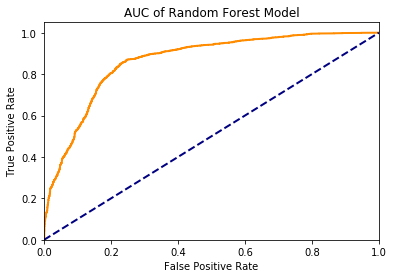

In [168]:
# Neural Network
mlp_fit = mlp(batch_size=128, learning_rate='adaptive').fit(X_train, y_train)
preds_mlp = mlp_fit.predict(X_test)

print(cr(y_test, preds_mlp))

print(accu(y_test, preds_mlp))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=mlp_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

C:\Users\user\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

   CERTIFIED       0.80      0.83      0.82      1902
      DENIED       0.81      0.78      0.80      1786

   micro avg       0.81      0.81      0.81      3688
   macro avg       0.81      0.81      0.81      3688
weighted avg       0.81      0.81      0.81      3688

0.8063991323210412


0.8773348735285426


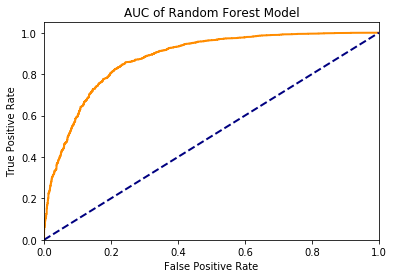

In [169]:
mlp_fit = mlp(learning_rate='adaptive', batch_size=128).fit(X_imp_train, y_train)
preds_mlp = mlp_fit.predict(X_imp_test)

print(cr(y_test, preds_mlp))

print(accu(y_test, preds_mlp))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=mlp_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.78      0.81      0.80      1902
      DENIED       0.79      0.76      0.78      1786

   micro avg       0.79      0.79      0.79      3688
   macro avg       0.79      0.79      0.79      3688
weighted avg       0.79      0.79      0.79      3688

0.7868763557483731


0.7865993596650194


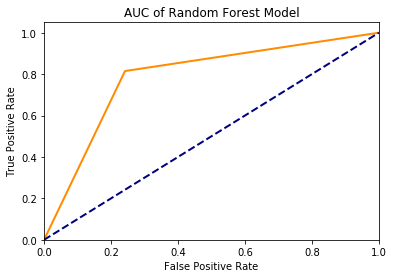

In [173]:
#CART

dtc_fit = dtc().fit(X_train, y_train)
preds_dtc = dtc_fit.predict(X_test)

print(cr(y_test, preds_dtc))

print(accu(y_test, preds_dtc))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=dtc_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.74      0.76      0.75      1902
      DENIED       0.74      0.71      0.72      1786

   micro avg       0.74      0.74      0.74      3688
   macro avg       0.74      0.74      0.74      3688
weighted avg       0.74      0.74      0.74      3688

0.7380694143167028


0.738726430479851


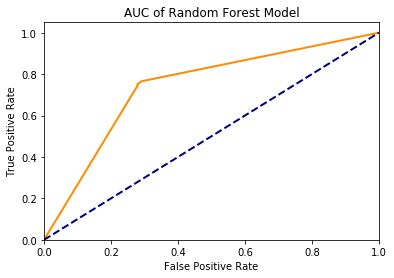

In [174]:
#from sklearn.tree import DecisionTreeClassifier as dtc
dtc_fit = dtc().fit(X_imp_train, y_train)
preds_dtc = dtc_fit.predict(X_imp_test)

print(cr(y_test, preds_dtc))

print(accu(y_test, preds_dtc))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=dtc_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.80      0.88      0.84      1902
      DENIED       0.86      0.76      0.81      1786

   micro avg       0.82      0.82      0.82      3688
   macro avg       0.83      0.82      0.82      3688
weighted avg       0.83      0.82      0.82      3688

0.8245661605206074


0.8954521850636389


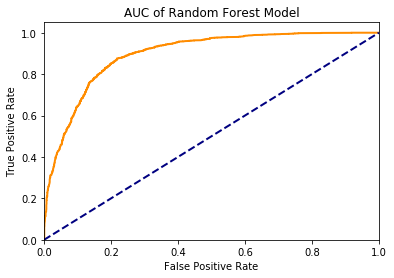

In [175]:
gbc_fit = gbc(n_estimators=1000, max_depth=5).fit(X_train, y_train)
preds_gbc = gbc_fit.predict(X_test)

print(cr(y_test, preds_gbc))

print(accu(y_test, preds_gbc))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=gbc_fit.predict_proba(X_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();

              precision    recall  f1-score   support

   CERTIFIED       0.79      0.84      0.82      1902
      DENIED       0.82      0.77      0.79      1786

   micro avg       0.80      0.80      0.80      3688
   macro avg       0.81      0.80      0.80      3688
weighted avg       0.81      0.80      0.80      3688

0.8045010845986985


0.8754620291247618


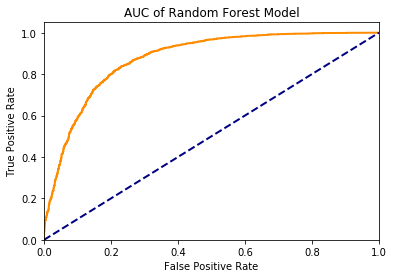

In [176]:
gbc_fit = gbc(n_estimators=1000, max_depth=5).fit(X_imp_train, y_train)
preds_gbc = gbc_fit.predict(X_imp_test)

print(cr(y_test, preds_gbc))

print(accu(y_test, preds_gbc))

#calculating auc
y_test_auc = [d[item] for item in y_test]
#preds_auc = [d[item] for item in preds]
preds_auc=gbc_fit.predict_proba(X_imp_test) 
preds_auc = preds_auc[:,0]
fpr, tpr, thresholds = roc_curve(y_test_auc,preds_auc,pos_label=1)
print("\n")
print(auc(fpr, tpr))
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Random Forest Model');
plt.show();